# Anomaly Detection Problems

## Multivariate Approach

This data contains two metrics for a particular server. Anomalous behavior can be an indication of various types of problems. The goal is to create a system that can handle a live feed of data to detect anomalies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

1 - Check that the training data is suitable for a multivariate modeling approach (multivariate_tr.csv & multivariate_ts.csv)
- i.e. check that the data appears to be from a multivariate Gaussian distribution
- you don't need to get too fancy with tests here

In [2]:
Xtrain = pd.read_csv('./data/multivariate_tr.csv')
Xtrain.head()

,X1,X2
0,4.403684,1.625136
1,4.187460,0.537484
2,3.481319,2.871732
3,4.610979,1.705542
4,7.742105,3.569791


In [3]:
Xtrain.describe()

,X1,X2
count,5000.000000,5000.000000
mean,5.355991,2.245740
std,1.856961,1.058475
min,-1.232979,-1.003655
25%,4.125419,1.523453
50%,5.353521,2.150443
75%,6.598291,2.849264
max,13.317971,8.477483


In [4]:
Xtest = pd.read_csv('./data/multivariate_ts.csv')
Xtest.head()

,X1,X2
0,3.333215,3.305589
1,5.494974,2.078626
2,7.447633,3.108583
3,4.853434,2.684147
4,3.295403,3.020483


In [5]:
Xtest.describe()

,X1,X2
count,25408.000000,25408.000000
mean,5.322931,2.461844
std,1.974247,1.054347
min,-1.643433,-1.467681
25%,3.992453,1.749390
50%,5.298202,2.373602
75%,6.649019,3.064187
max,14.298211,8.973606


In [6]:
from scipy.stats import multivariate_normal

def check_mult_norm(data, levels):
    cov = np.cov(data.values.T)
    mu = np.mean(data).values
    
    x = np.linspace(min(data.iloc[:, 0])-0.5, max(data.iloc[:, 0])+0.5, 1000)
    y = np.linspace(min(data.iloc[:, 1])-0.5, max(data.iloc[:, 1])+0.5, 1000)
    x, y = np.meshgrid(x, y)
    
    mult = multivariate_normal(mean=mu, cov=cov)
    z = mult.pdf(np.array([x.ravel(), y.ravel()]).T).reshape(x.shape)
    
    plt.figure(figsize=(16, 10))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
    plt.contour(x, y, z, levels=np.arange(0, 0.5, 0.005))

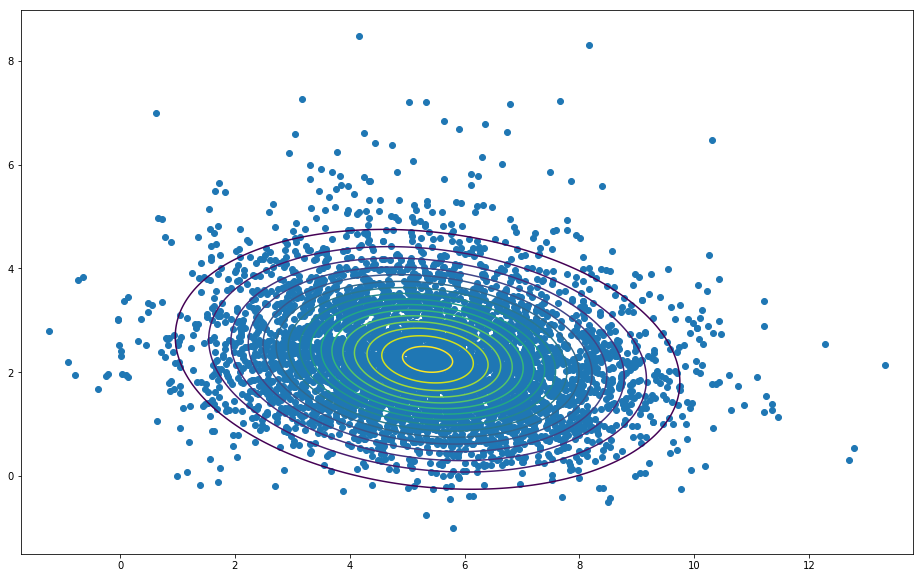

In [7]:
check_mult_norm(Xtrain, np.arange(0, 0.5, 0.005))

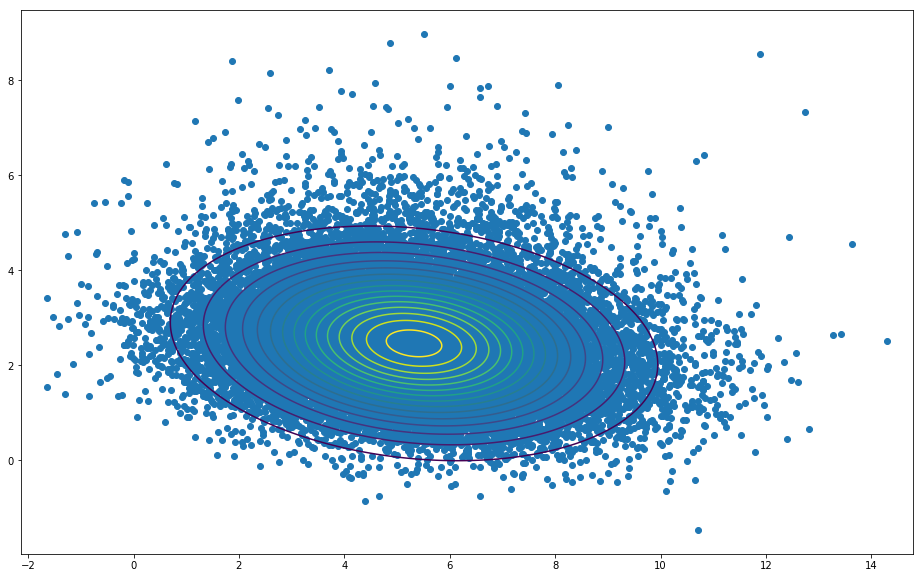

In [8]:
check_mult_norm(Xtest, np.arange(0, 0.5, 0.005))

2 - Check for any drift in the training data mean and std over time
- if there is drift, determine what span of time (window) should used for modeling incoming data

In [9]:
def calc_rolling_var(data, variable, variable_pos):
    rolling_mean = data[variable].cumsum() / np.arange(1, len(data)+1)
    rolling_var = []
    for i in np.arange(2, len(data)+1):
        rolling_var.append(np.sum((data.iloc[:i, variable_pos] - rolling_mean[i-1])**2) / i)
    return rolling_mean, np.array(rolling_var)

rolling_mean_x1, rolling_var_x1 = calc_rolling_var(Xtrain, 'X1', 0)
rolling_mean_x2, rolling_var_x2 = calc_rolling_var(Xtrain, 'X2', 1)

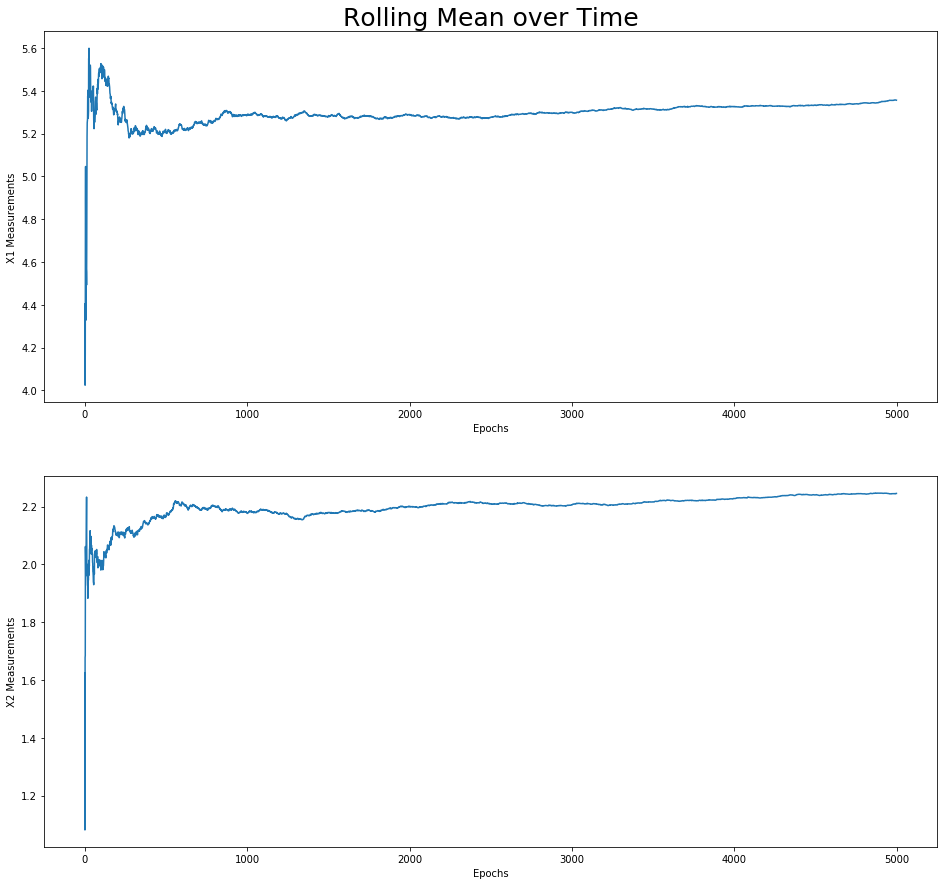

In [10]:
def plot_rollings(data1, data2, window, title, xlab, ylab1, ylab2):
    fig, ax = plt.subplots(2, 1, figsize=(16, 15))
    ax[0].plot(data1[window])
    ax[0].set_xlabel(xlab)
    ax[0].set_ylabel(ylab1)
    ax[0].set_title(title, size=25)
    ax[1].plot(data2[window])
    ax[1].set_xlabel(xlab)
    ax[1].set_ylabel(ylab2)

plot_rollings(rolling_mean_x1, rolling_mean_x2, np.arange(len(Xtrain)), 'Rolling Mean over Time', 'Epochs', 'X1 Measurements', 'X2 Measurements');

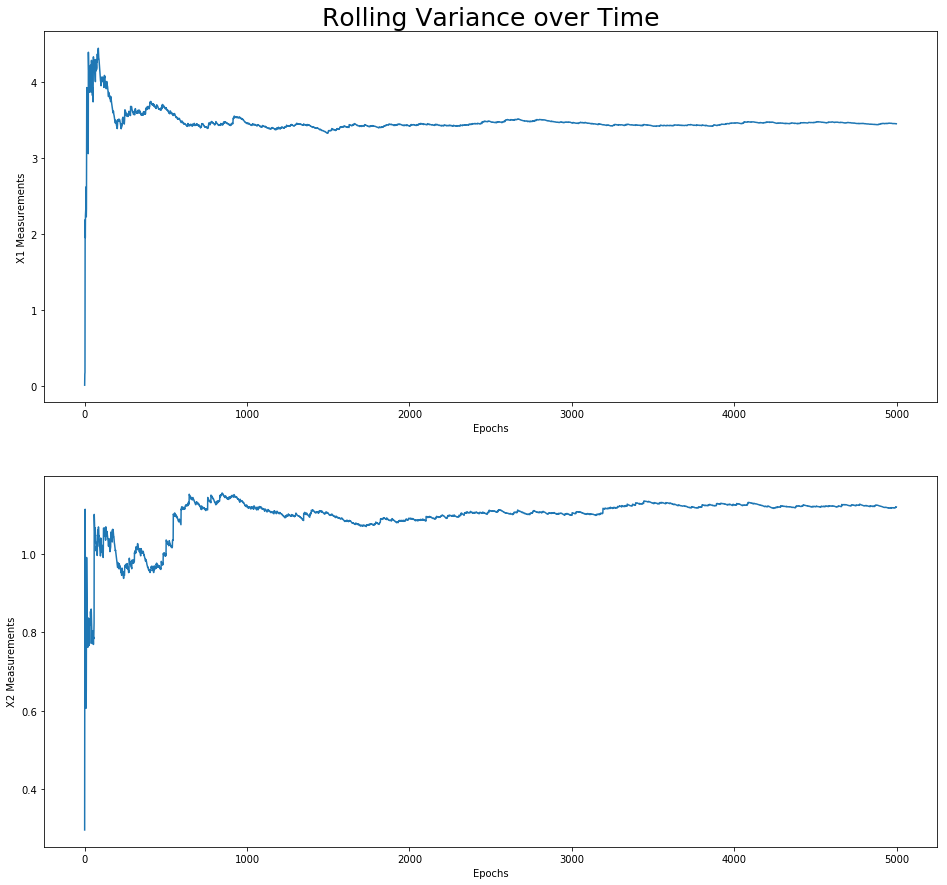

In [11]:
plot_rollings(rolling_var_x1, rolling_var_x2, np.arange(len(Xtrain)-1), 'Rolling Variance over Time', 'Epochs', 'X1 Measurements', 'X2 Measurements');

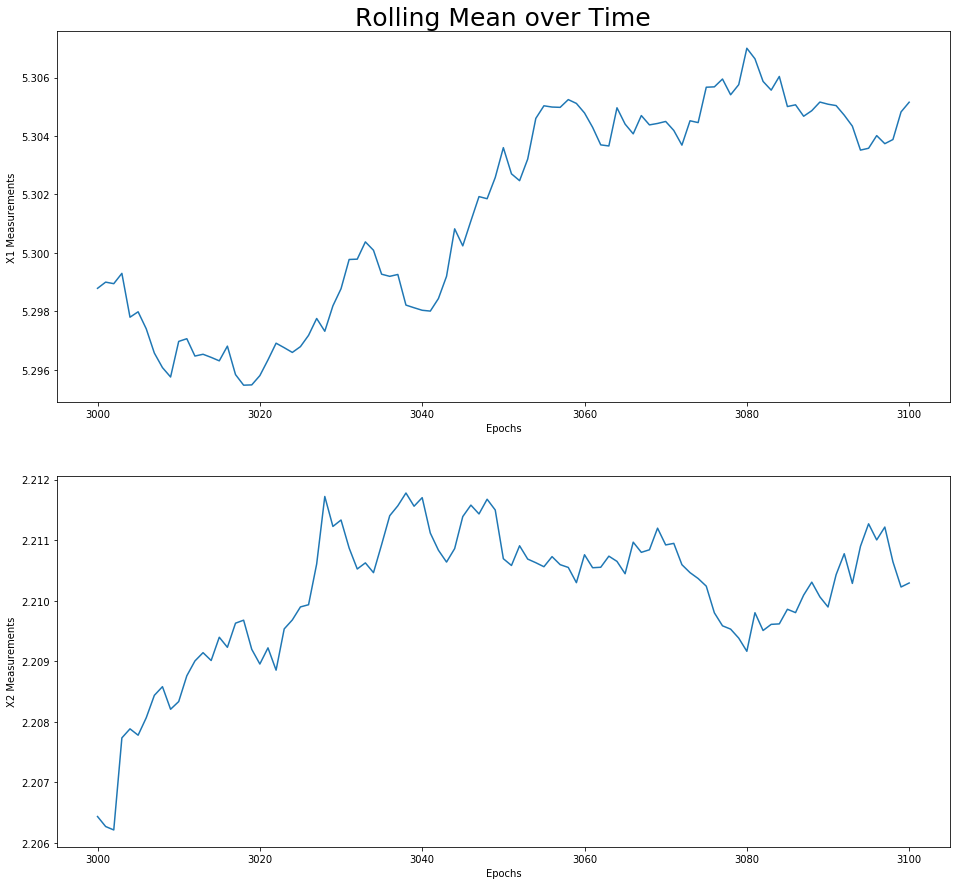

In [12]:
plot_rollings(rolling_mean_x1, rolling_mean_x2, np.arange(3000, 3101), 'Rolling Mean over Time', 'Epochs', 'X1 Measurements', 'X2 Measurements')

I think $N=10$ is a good window...

In the solution $N=1000$, I don't know why...

In [13]:
rolling_mean = []
for i in np.arange(1, len(Xtrain)+1):
    rolling_mean.append(np.sum(Xtrain.iloc[i-10:i, 0]) / 10)
rolling_mean = np.array(rolling_mean)
rolling_mean[10:20]

array([ 4.56820008,  4.53174258,  4.83127609,  5.20901821,  5.33377438,
        5.3729503 ,  5.62924027,  5.86830666,  6.31549763,  6.13364457])

In [14]:
def calc_rolling_var_windowed(data, variable_pos, window):
    rolling_mean = []
    for i in np.arange(1, len(data)+1):
        rolling_mean.append(np.sum(data.iloc[i-window:i, variable_pos]) / window)
    rolling_mean = np.array(rolling_mean)
    rolling_var = []
    for i in np.arange(2, len(data)+1):
        rolling_var.append(np.sum((data.iloc[i-window:i, variable_pos] - rolling_mean[i-1])**2) / window)
    return rolling_mean, np.array(rolling_var)

rolling_mean_x1_10, rolling_var_x1_10 = calc_rolling_var_windowed(Xtrain, 0, 1000)
rolling_mean_x2_10, rolling_var_x2_10 = calc_rolling_var_windowed(Xtrain, 1, 1000)

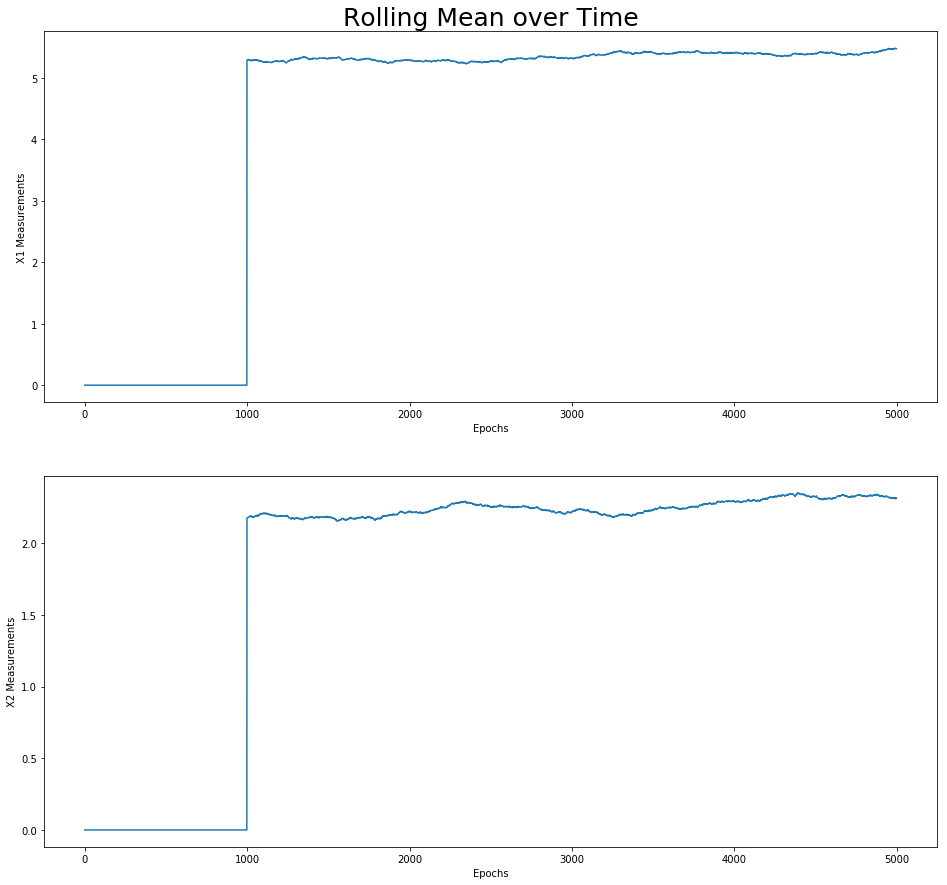

In [16]:
plot_rollings(rolling_mean_x1_10, rolling_mean_x2_10, np.arange(len(rolling_mean_x1_10)), 'Rolling Mean over Time', 'Epochs', 'X1 Measurements', 'X2 Measurements');

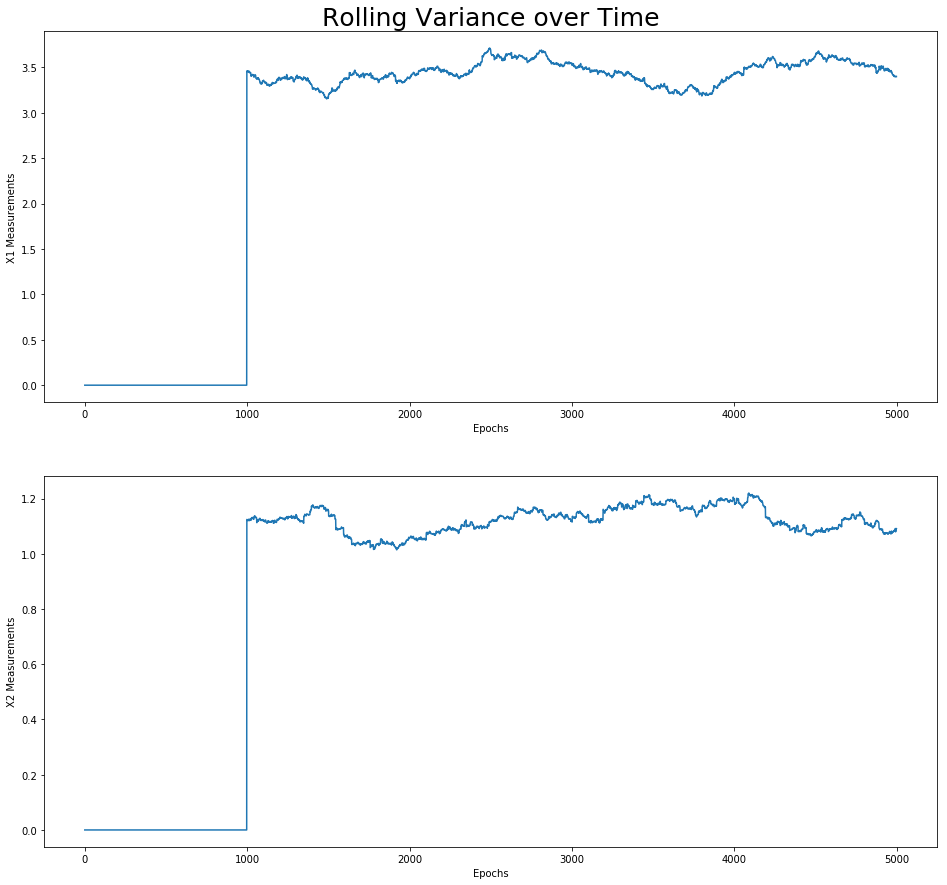

In [15]:
plot_rollings(rolling_var_x1_10, rolling_var_x2_10, np.arange(len(rolling_var_x1_10)), 'Rolling Variance over Time', 'Epochs', 'X1 Measurements', 'X2 Measurements');

3 - Create the following functions
- on that returns an estimated multivariate normal distribution for a given window of data
- another that determines if a single observation is an outlier and takes these params:
    - a single observation
    - the estimated distribution object
    - probability threshold: below which observation is outlier

In [18]:
def estd_multi(data):
    cov = np.cov(data.values.T)
    mu = np.mean(data).values
    return multivariate_normal(mean=mu, cov=cov)

In [19]:
def is_outlier(obs, distr, threshold):
    prob = distr.pdf(obs)
    if prob < threshold:
        return 1, prob
    else:
        return 0, prob

In [20]:
multi = estd_multi(Xtrain.iloc[:100, ])
print(is_outlier(Xtrain.iloc[152, ], multi, threshold=0.01))
print(is_outlier(Xtrain.iloc[1523, ], multi, threshold=0.01))

(0, 0.05019734538227362)
(1, 0.00025898842885697503)


4 - Create a function to simulate a live feed (a stream) of the test data
- returns a boolean list indicating if each observation was an outlier
- computes these one-by-one as they come in through simulated feed
- each observation should be based on last N observations
    - N is the windows size determined in (2)
- use the last N observations in the test data as a starting point
- use a threshold of 0.0001

In [21]:
def live_feed(stream_data, past_data, window, threshold = 0.0001):
    is_out = []
    for i in np.arange(len(stream_data)):
        data = past_data.iloc[-window:, ]
        multi = estd_multi(data)
        flag, _ = is_outlier(stream_data.iloc[i, ], multi, threshold)
        is_out.append(flag)
        past_data = past_data.append(stream_data.iloc[i, ])
    return is_out, past_data

In [22]:
past = Xtest.iloc[:100, ]
is_out, past = live_feed(Xtest.iloc[100:200, ], past, 10)

In [23]:
past.iloc[np.append(np.repeat(False, 100), (np.array(is_out)))==1, ]

,X1,X2
132,11.241290,2.801120
155,6.194804,6.152789
179,5.100967,3.841780


In [24]:
is_out, past = live_feed(Xtest.iloc[200:300, ], past, 10)
past.iloc[np.append(np.repeat(False, 200), (np.array(is_out)))==1, ]

,X1,X2
233,1.098334,2.882767
286,4.870404,8.778668
296,-0.387701,3.217592


5 - Create a single plot that has
- scatter plot of the test data highlighting detected outliers
- contour plot overlaid showing how the distribution pdf varies

In [25]:
past = Xtest.iloc[:1000, ]
is_out, _ = live_feed(Xtest.iloc[1000:, ], past, 1000)

In [26]:
np.append(np.repeat(False, 1000), (np.array(is_out)))[1000:1100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

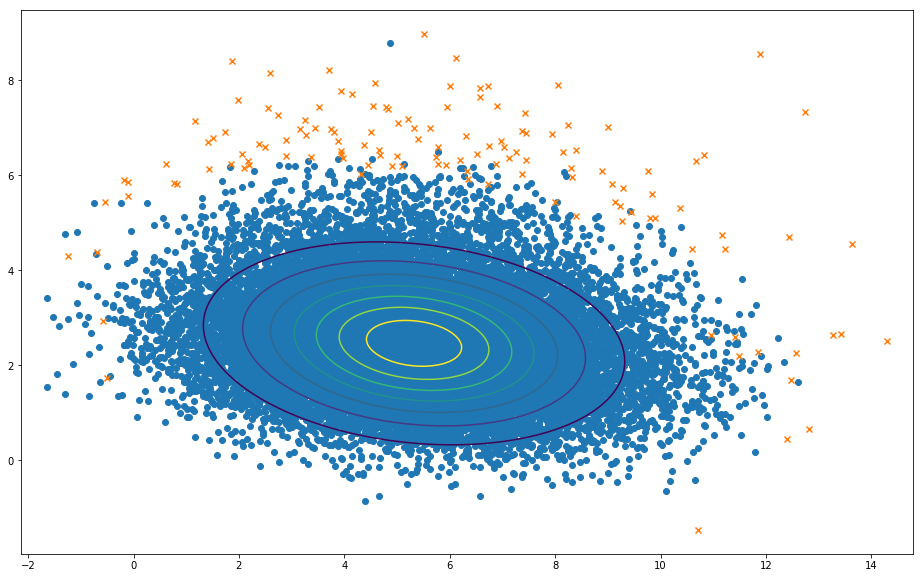

In [30]:
plt.figure(figsize=(16, 10))
plt.scatter(Xtest.iloc[np.append(np.repeat(False, 1000), (np.array(is_out)))==0, 0],
            Xtest.iloc[np.append(np.repeat(False, 1000), (np.array(is_out)))==0, 1], marker='o')
plt.scatter(Xtest.iloc[np.append(np.repeat(False, 1000), (np.array(is_out)))==1, 0],
            Xtest.iloc[np.append(np.repeat(False, 1000), (np.array(is_out)))==1, 1], marker='x')

# I'm drawing just 10 examples of the distribution in order to make the plot readable...
x = np.linspace(min(Xtest.iloc[:, 0])-0.5, max(Xtest.iloc[:, 0])+0.5, 1000)
y = np.linspace(min(Xtest.iloc[:, 1])-0.5, max(Xtest.iloc[:, 1])+0.5, 1000)
x, y = np.meshgrid(x, y)

# for i in range(10):

#     cov = np.cov(Xtest.iloc[i*2550:i*2550+10, ].values.T)
#     mu = np.mean(Xtest.iloc[i*2550:i*2550+10, ]).values

#     mult = multivariate_normal(mean=mu, cov=cov)
#     z = mult.pdf(np.array([x.ravel(), y.ravel()]).T).reshape(x.shape)
    
#     plt.contour(x, y, z, levels=[0.0001]);

cov = np.cov(Xtest.values.T)
mu = np.mean(Xtest).values

mult = multivariate_normal(mean=mu, cov=cov)
z = mult.pdf(np.array([x.ravel(), y.ravel()]).T).reshape(x.shape)

plt.contour(x, y, z);

6 - How do you think the threshold could be optimized?

I guess you could think of an expected number of anomalies in the data and try to find the best threshold for that, maybe using training data for this.

You could also try to optimize both parameters (threshold and window size) trying to avoid detecting points that aren't extreme with respect to the global multivariate normal distribution obtained from the training set...

## Detect Anomalous Number Of Defects

This dataset contains chronological data for a computer system. The data simply indicates if an error occurred at a given time with a 1, otherwise a 0 is output. This system has a fixed expectation value of 5 errors per thousand. The goal is to detect if there were an abnormal number of errors for any given time-window.

1 - Given the description and goal, what distribution should be used to model this data? (errors.csv)

I would use a binomial distribution with $p=0.005$.

In [210]:
errors = pd.read_csv('./data/errors.csv')
errors.head()

,0
0,0
1,0
2,0
3,0
4,0


In [211]:
errors.describe()

,0
count,457999.000000
mean,0.004884
std,0.069717
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


2 - Create a script that will simulate this data as a feed
- number of defects will only be analyzed every 1000 observations
- each 1000 will count as one block
- each of these blocks will be classified as anomalous or not (as a whole)
- use a threshold of 0.01

In [246]:
threshold = 0.01
n = 1000
p = 5/1000
n_blocks = int(np.ceil(len(errors) / 1000))

from scipy.stats import binom
distr = binom(p=p, n=n)

blocks = []
is_out = []
for i in np.arange(n_blocks):
    curr_count = errors[n*i:n*(i+1)].sum()[0]
    blocks.append(curr_count)
    is_out.append(distr.pmf(curr_count) < threshold)

print(is_out[:10])
print(blocks[:10])

[False, False, False, False, False, False, False, False, False, False]
[7, 7, 5, 8, 7, 5, 6, 1, 2, 4]


3 - Create a plot with the following properties
- x-axis: block number
- y-axis: number of errors in the block
- highlight blocks labeled as anomalies

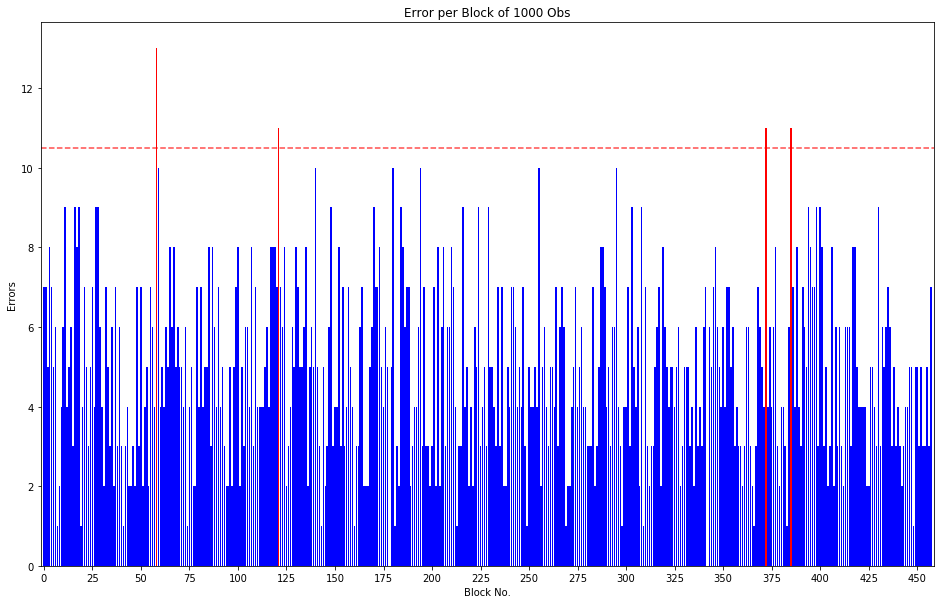

In [271]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(np.arange(n_blocks), blocks, color=['red' if out else 'blue' for out in is_out])
ax.set_title('Error per Block of 1000 Obs')
ax.set_xlabel('Block No.')
ax.set_ylabel('Errors')
ax.set_xlim(-1.5, n_blocks+0.5)
ax.hlines(10.5, -1.5, n_blocks+0.5, color='r', alpha=0.7, linestyles='--')
ax.xaxis.set_major_locator(plt.MaxNLocator(20));

## Anomaly Detection Using Cluster Analysis

This is a very common dataset (slightly modified) of three varieties of the iris flower; it will work well for clustering.

In [272]:
iris_train = pd.read_csv('./data/iris_train.csv')
iris_test = pd.read_csv('./data/iris_test.csv')

In [273]:
iris_train.head()

,0,1,2,3,label
0,5.5,3.5,1.3,0.2,0
1,5.0,3.5,1.6,0.6,0
2,5.8,2.7,4.1,1.0,1
3,5.2,3.5,1.5,0.2,0
4,6.7,3.0,5.2,2.3,2


In [275]:
iris_train.describe()

,0,1,2,3,label
count,100.00000,100.000000,100.000000,100.000000,100.000000
mean,5.73800,3.088000,3.525000,1.121000,0.920000
std,0.82887,0.430006,1.784239,0.778407,0.837022
min,4.30000,2.000000,1.000000,0.100000,0.000000
25%,5.00000,2.875000,1.500000,0.275000,0.000000
50%,5.70000,3.050000,4.000000,1.300000,1.000000
75%,6.40000,3.325000,5.100000,1.800000,2.000000
max,7.90000,4.400000,6.700000,2.500000,2.000000


1 - Fit the training data using k-means clustering (without labels) using a number a clusters determined by the label values

In [284]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
km.fit(iris_train.iloc[:, :4])
print(km.labels_)
print(km.cluster_centers_)

[1 1 0 1 2 0 1 2 2 1 2 2 0 1 2 2 0 0 2 2 0 0 1 2 0 0 1 2 0 1 1 2 1 2 2 2 1
 0 1 1 0 1 1 0 2 0 2 2 1 0 2 0 1 0 2 0 1 0 1 0 0 1 0 1 1 1 2 2 1 2 1 1 2 1
 0 1 2 1 2 2 0 1 2 1 0 2 2 2 1 0 1 2 2 1 1 1 2 1 0 1]
[[ 5.7         2.67777778  4.12222222  1.29259259]
 [ 4.97692308  3.37692308  1.44871795  0.25128205]
 [ 6.64117647  3.08235294  5.43235294  1.98235294]]


2 - Get the 98th percentile for distances from cluster centers for the training data
- one value for each label/clas

In [317]:
centers = np.array([list(km.cluster_centers_[lab]) for lab in km.labels_])
distances = np.sqrt(np.sum((iris_train.iloc[:, :4] - centers)**2, axis=1))

In [323]:
percentiles = np.array([np.percentile(distances[km.labels_==i], 98) for i in range(3)])

In [324]:
percentiles

array([ 1.25600049,  1.20603178,  1.76679386])

3 - Use these percentiles to determine outliers in the test data and create a 3d plot using the first three attributes and highlight outliers

In [328]:
pred = km.predict(iris_test.iloc[:, :4])
centers = np.array([list(km.cluster_centers_[lab]) for lab in pred])
distances = np.sqrt(np.sum((iris_test.iloc[:, :4] - centers)**2, axis=1))
is_out = [distances[i] > percentiles[lab] for i, lab in enumerate(pred)]

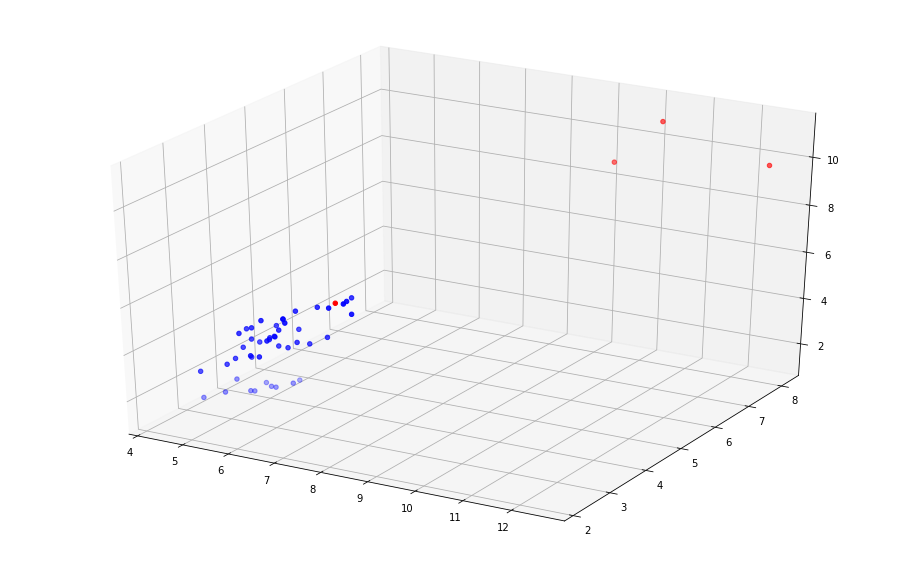

In [337]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(iris_test.iloc[:, 0],
           iris_test.iloc[:, 1],
           iris_test.iloc[:, 2],
           color=['red' if out else 'blue' for out in is_out]);